# Overview

Notebook ini digunakan untuk mempersiapkan data agar siap digunakan untuk forecasting

# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import pearsonr, zscore
import statsmodels.api as sm
import calendar
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from pandas.tseries.frequencies import to_offset
from collections import Counter
from typing import Tuple, Dict
sns.set(style="whitegrid")

# Loading the Data

In [2]:
# read data
df = pd.read_parquet("data/preprocessed/cleaned_data.parquet")

# Preparation

## Monthly Aggregation

Granularity yang direkomendasi adalah forecast bulanan, oleh karena itu kita akan aggregat sales bulanan per series.
Komponen yang dibutuhkan adalah

- unique_id
- ds (date)
- y (metric yang ingin diforecast)
- variabel exogenous lainnya

In [3]:
# Buat unique id by sku_id and country
df["unique_id"] = (
    df["sku_id"].astype(str) + " | " +
    df["country"].astype(str)
)

# Aggregate bulanan
monthly_agg = df[
(df['order_date_month']<'2011-12-01')&
(~df['order_id_adjustment'])&
(~df['sku_id_no_digit'])&
(~df['order_id_cancelled'])].groupby(['unique_id','order_date_month']).agg({
    'sku_id':'first',
    'country':'first',
    'quantity':'sum',
    'adjusted_gmv':'sum',
'order_id':'nunique',
'customer_id':'nunique'}).reset_index()

# rename column & add feature price
monthly_agg.columns = ['unique_id','ds','sku_id','country','quantity','gmv','total_order','total_customer']
monthly_agg['price'] = monthly_agg['gmv']/monthly_agg['quantity']

## Fill in Missing Date

In [4]:
# Dapatkan min dan max date
min_date = monthly_agg['ds'].min()
max_date = monthly_agg['ds'].max()

# Dapatkan rentang bulan dari min sampai max date
full_dates = pd.date_range(min_date, max_date, freq="MS")
full_dates_df = pd.DataFrame({'ds':full_dates}).sort_values('ds')

# Dapatkan master unique_id, dan ambil data pembelian pertama per unique_id nya
unique_id_df = monthly_agg.sort_values('ds')[['unique_id','ds','sku_id','country']].groupby('unique_id').head(1)
unique_id_df = unique_id_df.rename(columns={'ds':'first_ds'})

# Buat kolom dummy untuk cross join
full_dates_df['key'] = 'key'
unique_id_df['key'] = 'key'
master_data = unique_id_df.merge(full_dates_df,on='key')

# Merge ke original data
monthly_agg = master_data.drop(columns='key').merge(monthly_agg, on=['unique_id','sku_id','country','ds'],how='left')

# Drop data sebelum pembelian pertama
monthly_agg = monthly_agg[monthly_agg['ds']>=monthly_agg['first_ds']]

# Drop kolom first_ds
monthly_agg = monthly_agg.drop(columns='first_ds')

monthly_agg['missing_quantity'] = monthly_agg['quantity'].isnull()

## Fill missing value

In [5]:
# Imputasi dengan 0 untuk data yang missing (kecuali price)
for col in ['quantity','gmv','total_order','total_customer']:
    monthly_agg[col] = monthly_agg[col].fillna(0)

# Imputasi price dengan forward fill
monthly_agg = monthly_agg.sort_values(['unique_id','ds'])
monthly_agg['price'] = monthly_agg.groupby('unique_id')['price'].ffill()

## Group-level summaries (Mean, median, cv, etc by group)

In [6]:
# Fungsi untuk generate stat desc per group
focus_cols = ['quantity','missing_quantity']
def summarize_group(df, keys, metrics):
    """Return group-level summary with mean, median, std, CV, min, max, count."""
    agg_dict = {}
    for col in metrics:
        if col=='missing_quantity':
            agg_dict[col] = ["mean"]
        else:
            agg_dict[col] = ["count", "mean", "median", "std", "min", "max"]
    out = (
        df.groupby(keys)
          .agg(agg_dict)
          .rename(columns={"std": "std_dev"})   # optional rename
    )
    # Flatten MultiIndex kolom → 'units_sold_mean', dst.
    out.columns = ["_".join(col).strip() for col in out.columns]
    
    # Tambahkan Coefficient of Variation (CV = std / mean)
    for col in metrics:
        if col != 'missing_quantity':
            out[f"{col}_cv"] = out[f"{col}_std_dev"] / out[f"{col}_mean"]
    
    return out.reset_index()
    
summary_df = summarize_group(monthly_agg, ["unique_id"], focus_cols)

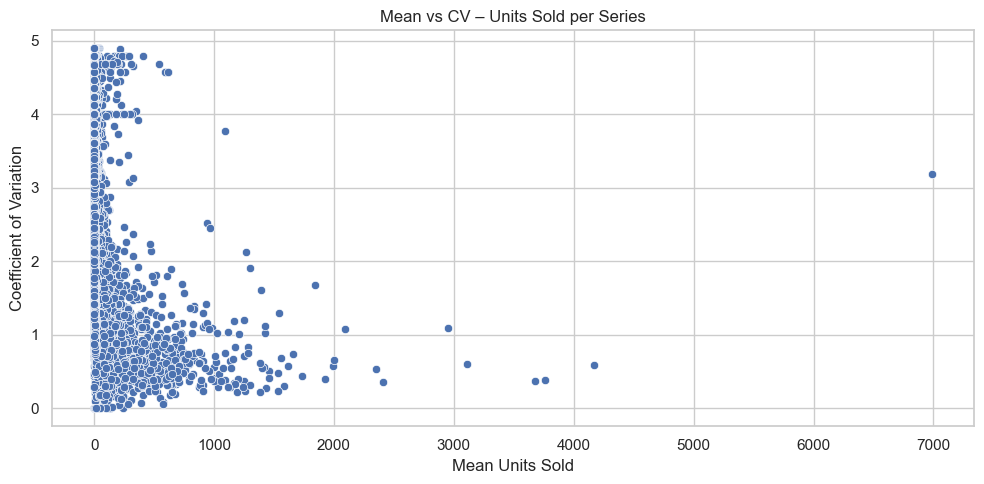

In [7]:
# Scatter mean vs CV untuk units_sold
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=summary_df,
    x='quantity_mean',
    y='quantity_cv'
)
plt.title('Mean vs CV – Units Sold per Series')
plt.xlabel('Mean Units Sold')
plt.ylabel('Coefficient of Variation')
plt.tight_layout()
plt.show()

- Tedapat Inverse relationship
- *Series* dengan **mean tinggi** (> 1000 unit/bln) mayoritas memiliki **CV rendah** (< 1), artinya permintaan lebih stabil 
- Sebaliknya, *series* dengan **mean rendah** (< 100 unit/bln) sering kali menunjukkan **CV tinggi** (> 2), menandakan permintaan fluktuatif.

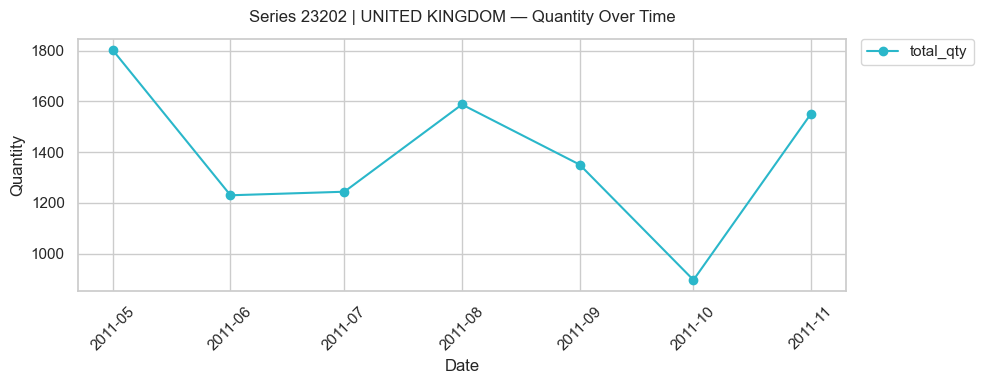

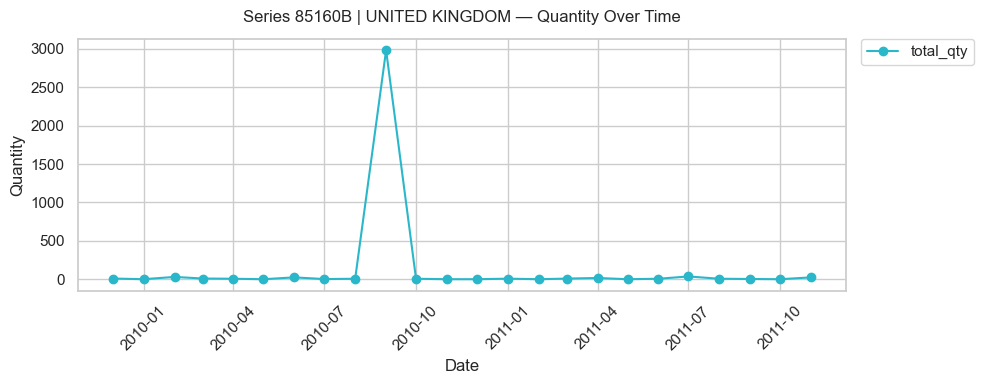

In [8]:
def plot_series(unique_id) :
    "Fungsi untuk plot series"
    df_plot = monthly_agg[monthly_agg["unique_id"] == unique_id].copy()
    df_plot["ds"] = pd.to_datetime(df_plot["ds"], errors="coerce")
    df_plot = df_plot.sort_values("ds")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(df_plot["ds"], df_plot["quantity"],
             marker="o", linestyle="-", color="#2AB7CA", label="total_qty")
    
    # Styling
    plt.title(f"Series {unique_id} — Quantity Over Time", pad=12)
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", 
              bbox_to_anchor=(1.02, 1), 
              borderaxespad=0,)
    plt.tight_layout()
    plt.show()

# Series dengan high quantity, tapi low CV (Sales stabil)
sample_series_1 = summary_df[(summary_df["quantity_mean"] > 1000)&(summary_df['missing_quantity_mean']<0.3)].sort_values('quantity_cv')['unique_id'].values[0]
plot_series(sample_series_1)

# Series dengan low quantity, tapi high CV (Sales Fluktuatif)
sample_series_2 = summary_df[(summary_df["quantity_mean"] < 1000)&(summary_df['missing_quantity_mean']<0.3)].sort_values('quantity_cv',ascending=False)['unique_id'].values[0]
plot_series(sample_series_2)
   

Pada series ke 2, terdapat spike yang sangat tinggi dan bulan lainnya mempunyai sales yang rendah

In [9]:
# Join summary series dengan monthly_agg
monthly_agg = monthly_agg.merge(summary_df,on=['unique_id'],how='left')

In [10]:
# Export ke parquet
monthly_agg.to_parquet('data/preprocessed/forecast_ready.parquet')